### base64
https://stackoverflow.com/questions/22351254/python-script-to-convert-image-into-byte-array/22351973

In [29]:
import base64
import os

from PIL import Image
from netCDF4 import Dataset
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_crop_resize_image(arr, resize=(1000, 800),
                          hstart=500/5500, hend=1300/5500,
                          wstart=2300/5500, wend=3100/5500,
                          normalize=True):
    
    # crop image
    h, w = arr.shape    
    arr = arr[int(h*hstart):int(h*hend), int(w*wstart):int(w*wend)]
    
    if normalize:
        arr = (arr - arr.min()) / (arr.max() - arr.min()) * 255
    
    # resize image
    prev_dtype = str(arr.dtype)
    img = Image.fromarray(arr.astype('uint8')).resize(resize[::-1])
    arr = np.array(img).astype(prev_dtype)
    
    return arr

In [3]:
def read_vis(str_time, base_ptah='/mnt/sda1/research/data/tmp_gk2a/'):
    
#     file_name = f'gk2a_ami_le1b_vi004_fd010ge_{str_time}.nc'
#     file_name = f'gk2a_ami_le1b_vi006_fd005ge_{str_time}.nc'
    file_name = f'gk2a_ami_le1b_vi008_fd010ge_{str_time}.nc'
    ds = Dataset(os.path.join(base_ptah, file_name))
    arr = np.array(ds['image_pixel_values'][:])
    
    return arr

In [4]:
def read_cld(str_time, base_ptah='/mnt/sda1/research/data/tmp_gk2a/'):
    
    file_name = f'gk2a_ami_le2_cld_fd020ge_{str_time}.nc'    
    ds = Dataset(os.path.join(base_ptah, file_name))
    arr = np.array(ds['CLD'][:])
    arr = 2 - arr
    
    return arr

In [5]:
def read_swrad(str_time, base_path='/mnt/sda1/research/data/tmp_gk2a/'):
    file_name = f'gk2a_ami_le2_swrad_fd020ge_{str_time}.nc'
    ds = Dataset(os.path.join(base_path, file_name))
    arr = np.array(ds['SWRAD'][:])
    return arr

In [6]:
def dense_optical_flow(prev_frame, next_frame):
    
    def normalize(cld):
        return (cld.astype('float')*255/2.).astype('uint8')
    
    prev_frame = normalize(prev_frame)
    next_frame = normalize(next_frame)
    
    flow = cv2.calcOpticalFlowFarneback(
        prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    
    return prev_frame, next_frame, flow

In [7]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

In [8]:
def draw_flow(img, flow, step=16):
    
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

In [9]:
raw_vis = read_vis('202111190200')

In [11]:
raw_vis.shape

(11000, 11000)

In [12]:
raw_cld = read_cld('202111190200')

In [14]:
raw_cld.shape

(5500, 5500)

In [20]:
base_path = '/mnt/sda1/research/data/tmp_gk2a/'

In [19]:
file_name = 'gk2a_ami_le2_swrad_fd020ge_202111180550.nc'

In [21]:
ds = Dataset(os.path.join(base_path, file_name))
# arr = np.array(ds['SWRAD'][:])

In [34]:
ds['RSR'][:]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=65535,
  dtype=float32)

In [17]:
raw_swrad = read_swrad('202111190200')

IndexError: SWRAD not found in /

In [10]:
arr_vis = get_crop_resize_image(read_vis('202111190200'), normalize=True)
arr_cld = get_crop_resize_image(read_cld('202111190200'), normalize=False)

In [11]:
prev_frame = get_crop_resize_image(read_cld('202111190100'), normalize=False)
next_frame = get_crop_resize_image(read_cld('202111190200'), normalize=False)

arr1, arr2, flow = dense_optical_flow(prev_frame, next_frame)

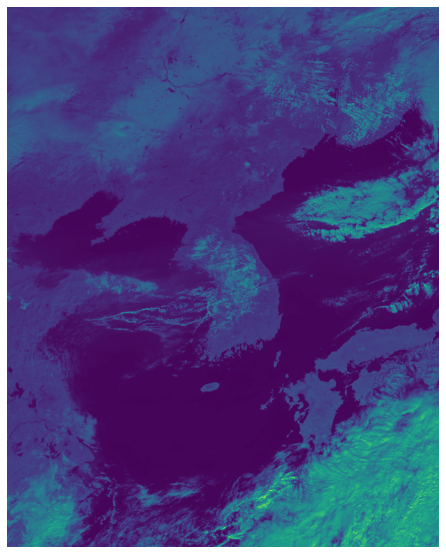

In [11]:
fig, ax = plt.subplots(1, 1)
ax.imshow(arr_vis)
ax.axis('off')
fig.subplots_adjust(right=2, top=2)

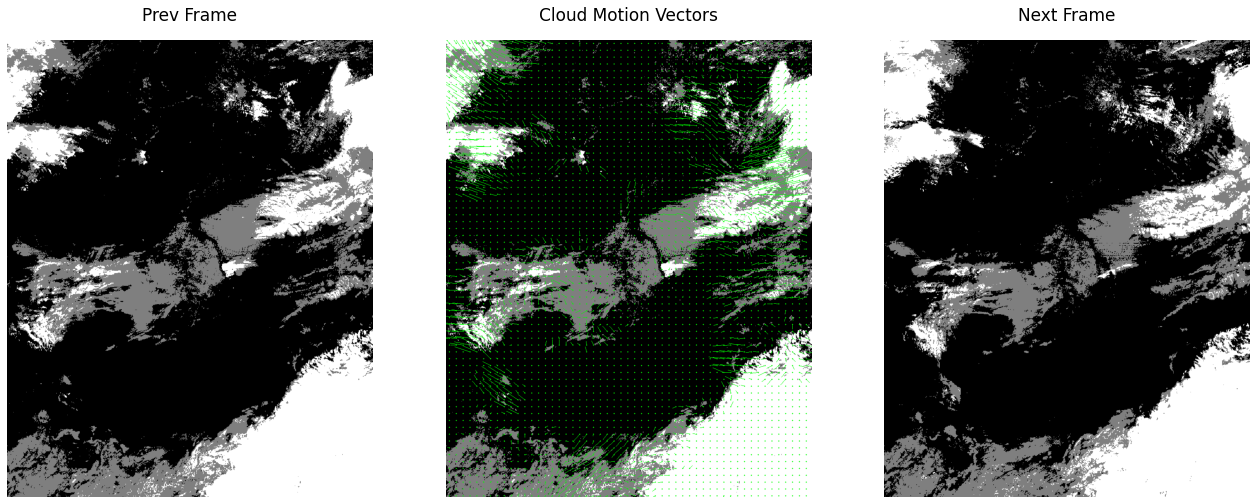

In [12]:
arr_flow = draw_flow(arr1, -flow, step=15)
images = [arr1, arr_flow, arr2]
titles = ['Prev Frame', 'Cloud Motion Vectors', 'Next Frame']

fig, ax_arr = plt.subplots(1, 3)
for i in range(3):
    ax = ax_arr[i]
    ax.axis('off')
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i], fontsize=17, y=1.03)

# fig.suptitle(f'관측 날짜: {target_dt.date()}', x=1.5, y=1.65, fontsize=20, fontweight='bold')
fig.subplots_adjust(right=3, top=3)

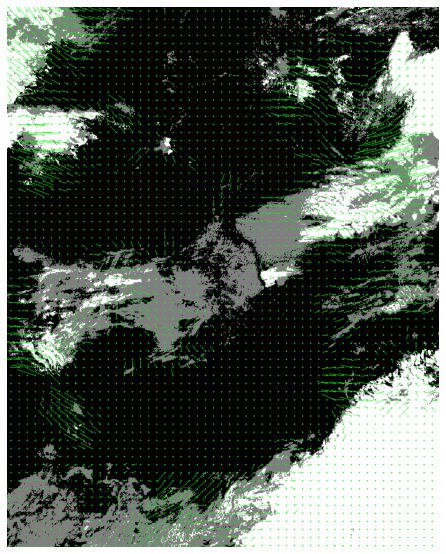

In [13]:
fig, ax = plt.subplots(1, 1)
ax.imshow(arr_flow, cmap='gray')
ax.axis('off')
fig.subplots_adjust(right=2, top=2)

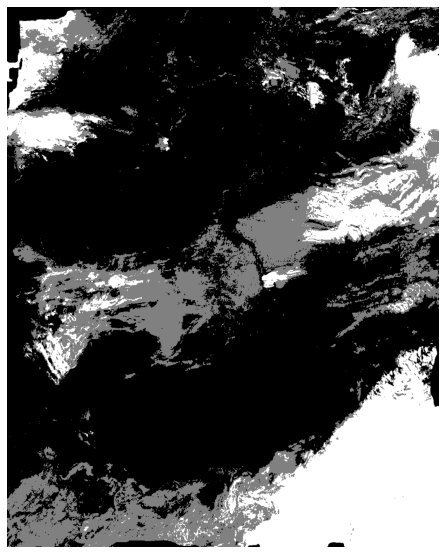

In [14]:
fig, ax = plt.subplots(1, 1)
ax.imshow(warp_flow(prev_frame, flow), cmap='gray')
ax.axis('off')
fig.subplots_adjust(right=2, top=2)

In [12]:
prev_frame = get_crop_resize_image(read_cld('202111190100'), normalize=False)
cur_frame = get_crop_resize_image(read_cld('202111190130'), normalize=False)
next_frame = get_crop_resize_image(read_cld('202111190200'), normalize=False)

arr1, arr2, flow = dense_optical_flow(prev_frame, cur_frame)

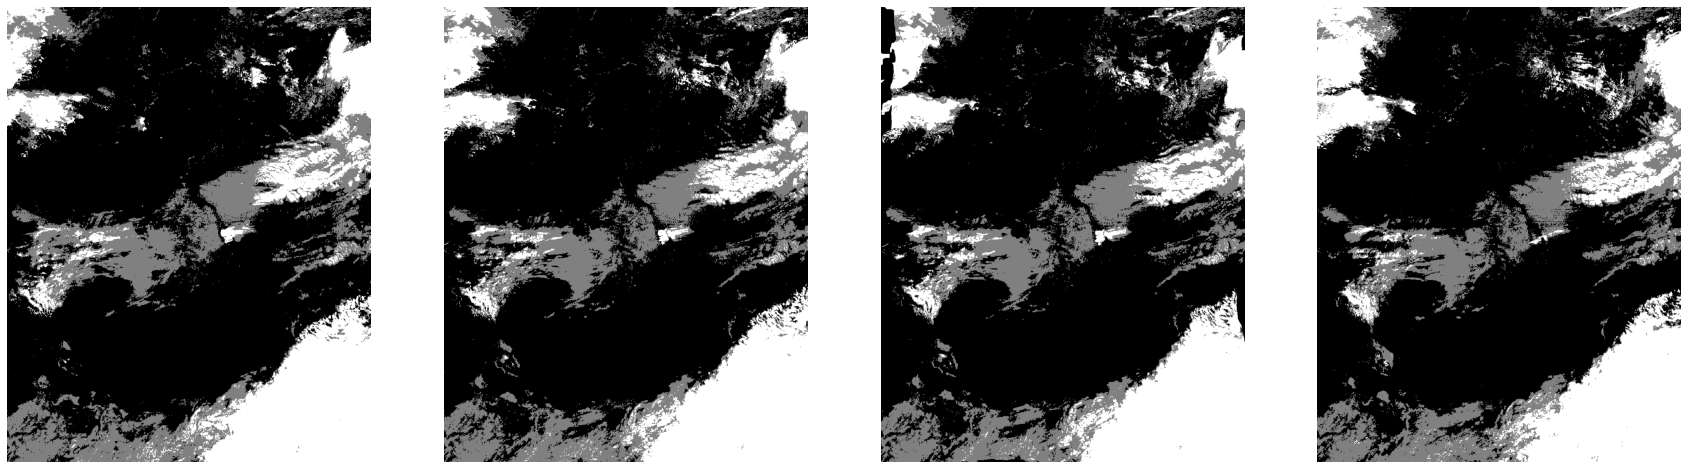

In [13]:
next_frame_pred = warp_flow(cur_frame, flow)
fig, ax = plt.subplots(1, 4)
ax[0].imshow(prev_frame, cmap='gray')
ax[0].axis('off')
ax[1].imshow(cur_frame, cmap='gray')
ax[1].axis('off')
ax[2].imshow(next_frame_pred, cmap='gray')
ax[2].axis('off')
ax[3].imshow(next_frame, cmap='gray')
ax[3].axis('off')
fig.subplots_adjust(right=4, top=4)

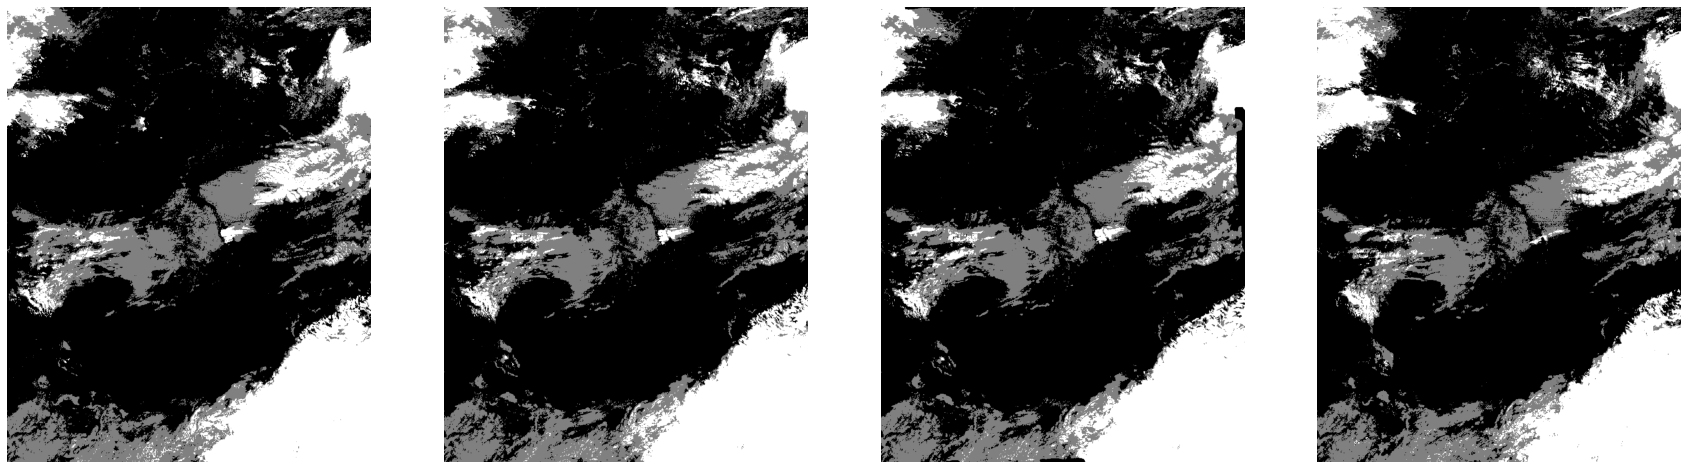

In [15]:
next_frame_pred = warp_flow(cur_frame, -flow)
fig, ax = plt.subplots(1, 4)
ax[0].imshow(prev_frame, cmap='gray')
ax[0].axis('off')
ax[1].imshow(cur_frame, cmap='gray')
ax[1].axis('off')
ax[2].imshow(next_frame_pred, cmap='gray')
ax[2].axis('off')
ax[3].imshow(next_frame, cmap='gray')
ax[3].axis('off')
fig.subplots_adjust(right=4, top=4)

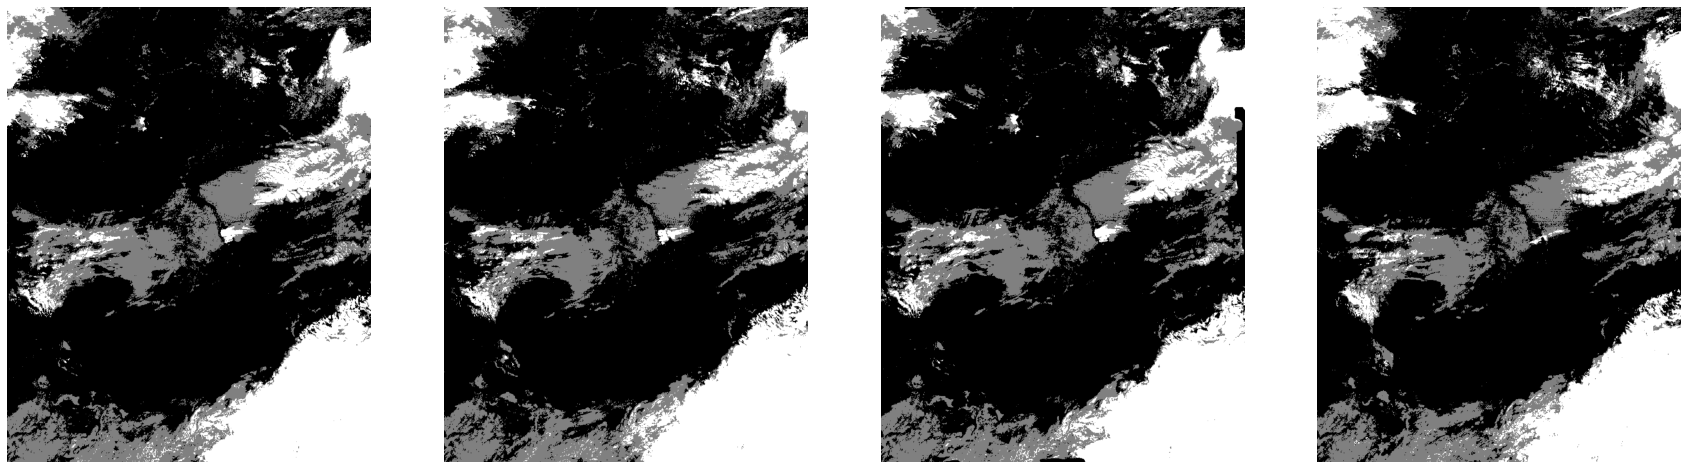

In [19]:
cur_frame_pred = warp_flow(prev_frame, -flow)
fig, ax = plt.subplots(1, 4)
ax[0].imshow(prev_frame, cmap='gray')
ax[0].axis('off')
ax[1].imshow(cur_frame, cmap='gray')
ax[1].axis('off')
ax[2].imshow(cur_frame_pred, cmap='gray')
ax[2].axis('off')
ax[3].imshow(next_frame, cmap='gray')
ax[3].axis('off')
fig.subplots_adjust(right=4, top=4)

In [22]:
(cur_frame - cur_frame_pred).mean()

21.4071725

In [23]:
(cur_frame - warp_flow(prev_frame, flow)).mean()

14.67440125

In [26]:
(next_frame - warp_flow(cur_frame, flow)).mean()

15.29488

In [28]:
(next_frame - warp_flow(cur_frame, -flow)).mean()

20.22956

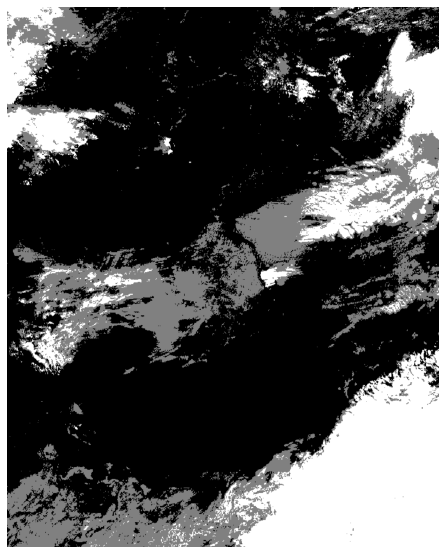

In [57]:
fig, ax = plt.subplots(1, 1)
ax.imshow(prev_frame, cmap='gray')
ax.axis('off')
fig.subplots_adjust(right=2, top=2)

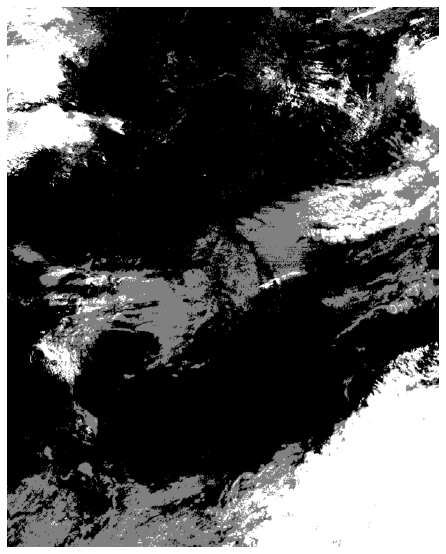

In [17]:
fig, ax = plt.subplots(1, 1)
ax.imshow(next_frame, cmap='gray')
ax.axis('off')
fig.subplots_adjust(right=2, top=2)

## save

In [36]:
import json

In [30]:
var_name = 'cloudmotion'

In [31]:
cur_data = flow

In [33]:
obs_datetime = '202111190200'

In [32]:
output = {
    'dtype': str(cur_data.dtype),
    'shape': cur_data.shape,
    'data': base64.b64encode(cur_data).decode('utf8')
}

In [37]:
with open(f'gk2a_{var_name}_{obs_datetime}.json', 'w') as f:
    json.dump(output, f)

## read

In [22]:
with open('data.json', 'r') as f:
    data = json.load(f)

## restore

In [23]:
restored = np.frombuffer(    
    base64.decodebytes(data['data'].encode('utf-8')), dtype='float32'
).reshape(1000, 800, 2)

In [24]:
np.abs(flow - restored).max()

0.0